## Setup

In [104]:
# transformer_testing.py
import os, sys, json
import joblib
import numpy as np
import pandas as pd
import gseapy as gp
import torch
import torch.nn.functional as F
import random
from itertools import cycle

from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
from scipy.stats import rankdata
from matplotlib.ticker import FuncFormatter, MultipleLocator
from re import sub
from tqdm import tqdm
from sklearn.metrics import r2_score
import logging
import matplotlib.pyplot as plt

import sys
PROJECT_DIR = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER"
SRC_DIR = str(Path(PROJECT_DIR) / "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

from datetime import datetime
from config.settings_hpc import *

logging.basicConfig(level=logging.INFO, format='%(message)s')

from multiomic_transformer.models.model import MultiomicTransformer
from multiomic_transformer.datasets.dataset import MultiChromosomeDataset, SimpleScaler, fit_simple_scalers

GROUND_TRUTH_DIR = Path(PROJECT_DIR, "data/ground_truth_files")

### Load Ground Truth

In [105]:

def load_ground_truth(ground_truth_file):
    if ground_truth_file.suffix == ".csv":
        sep = ","
    elif ground_truth_file.suffix == ".tsv":
        sep="\t"
        
    ground_truth_df = pd.read_csv(ground_truth_file, sep=sep)
    
    if ground_truth_file.name == "chip_atlas_tf_peak_tg_dist.csv":
        ground_truth_df = ground_truth_df[["source_id", "target_id"]]

    ground_truth_df = ground_truth_df.rename(columns={ground_truth_df.columns[0]: "Source", ground_truth_df.columns[1]: "Target"})
    ground_truth_df["Source"] = ground_truth_df["Source"].astype(str).str.upper()
    ground_truth_df["Target"] = ground_truth_df["Target"].astype(str).str.upper()
    
    return ground_truth_df


### Define Common Functions

In [123]:
def nanaware_per_gene_stats(y_true, y_pred, eps=1e-8):
    """Compute per-gene metrics accounting for NaN entries."""
    N, G = y_true.shape
    r2 = np.full(G, np.nan, dtype=np.float64)
    pearson = np.full(G, np.nan, dtype=np.float64)
    mae = np.full(G, np.nan, dtype=np.float64)
    rmse = np.full(G, np.nan, dtype=np.float64)
    n_obs = np.zeros(G, dtype=np.int32)

    for j in range(G):
        mask = np.isfinite(y_true[:, j]) & np.isfinite(y_pred[:, j])
        m = mask.sum()
        n_obs[j] = m
        
        if m < 2:
            continue
            
        yt = y_true[mask, j].astype(np.float64)
        yp = y_pred[mask, j].astype(np.float64)

        diff = yt - yp
        mae[j] = np.mean(np.abs(diff))
        rmse[j] = np.sqrt(np.mean(diff**2))

        yt_c = yt - yt.mean()
        yp_c = yp - yp.mean()
        yt_std = np.sqrt((yt_c**2).sum())
        yp_std = np.sqrt((yp_c**2).sum())
        if yt_std > 0 and yp_std > 0:
            pearson[j] = (yt_c @ yp_c) / (yt_std * yp_std)

        sst = ((yt - yt.mean())**2).sum()
        sse = (diff**2).sum()
        r2[j] = 1.0 - sse / (sst + eps)

    return {"r2": r2, "pearson": pearson, "mae": mae, "rmse": rmse, "n_obs": n_obs}

def load_model(selected_experiment_dir, checkpoint_file, device):
    # 1) Load test loader and checkpoint
    test_loader = torch.load(selected_experiment_dir / "test_loader.pt", weights_only=False)

    ckpt_path = os.path.join(selected_experiment_dir, checkpoint_file)
    state = torch.load(ckpt_path, map_location="cpu")

    # 2) Recreate model EXACTLY as in training
    model = MultiomicTransformer(
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        num_layers=NUM_LAYERS,
        d_ff=D_FF,
        dropout=DROPOUT,
        tf_vocab_size=len(state["tf_scaler_mean"]),
        tg_vocab_size=len(state["tg_scaler_mean"]),
        use_bias=USE_DISTANCE_BIAS,
        use_shortcut=USE_SHORTCUT,
        use_motif_mask=USE_MOTIF_MASK,
        use_edge_head=True,
        edge_extra_dim=0,
        edge_hidden_dim=128,
    )

    if isinstance(state, dict) and "model_state_dict" in state:
        model.load_state_dict(state["model_state_dict"])
    else:
        model.load_state_dict(state)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()

    # 3) Rebuild scalers on the SAME DEVICE as inputs
    tg_scaler = SimpleScaler(
        mean=torch.as_tensor(state["tg_scaler_mean"], device=device, dtype=torch.float32),
        std=torch.as_tensor(state["tg_scaler_std"],  device=device, dtype=torch.float32),
    )
    tf_scaler = SimpleScaler(
        mean=torch.as_tensor(state["tf_scaler_mean"], device=device, dtype=torch.float32),
        std=torch.as_tensor(state["tf_scaler_std"],  device=device, dtype=torch.float32),
    )

    return model, test_loader, tg_scaler, tf_scaler

def balance_pos_neg(df, label_col="is_gt", random_state=0):
    rng = np.random.default_rng(random_state)
    df = df.copy()
    pos_df = df[df[label_col]]
    neg_df = df[~df[label_col]]

    n_pos = len(pos_df)
    n_neg = len(neg_df)
    if n_pos == 0 or n_neg == 0:
        print("No positives or negatives, skipping balance")
        return df

    if n_neg < n_pos:
        pos_idx = rng.choice(pos_df.index.to_numpy(), size=n_neg, replace=False)
        pos_sample = pos_df.loc[pos_idx]
        neg_sample = neg_df
    else:
        pos_sample = pos_df
        neg_idx = rng.choice(neg_df.index.to_numpy(), size=n_pos, replace=False)
        neg_sample = neg_df.loc[neg_idx]

    balanced = pd.concat([pos_sample, neg_sample], axis=0)
    return balanced.sample(frac=1.0, random_state=random_state).reset_index(drop=True)


def create_random_distribution(scores: pd.Series, seed: int = 42) -> np.ndarray:
    random.seed(seed)
    uniform_distribution = np.random.uniform(low = scores.min(), high = scores.max(), size = len(scores))
    resampled_scores = np.random.choice(uniform_distribution, size=len(scores), replace=True)
    return resampled_scores

def compute_curves(df, score_col, label_col="is_gt", balance=True, name=""):
    """Return AUROC, AUPRC, and PR/ROC curves for one method."""
    df = df.dropna(subset=[score_col]).copy()
    
    if balance:
        df = balance_pos_neg(df, label_col=label_col, random_state=0)
    
    y = df[label_col].astype(int).values
    s = df[score_col].values

    auroc = roc_auc_score(y, s)
    auprc = average_precision_score(y, s)

    prec, rec, _ = precision_recall_curve(y, s)
    fpr, tpr, _ = roc_curve(y, s)

    return {
        "name": name,
        "auroc": auroc,
        "auprc": auprc,
        "prec": prec,
        "rec": rec,
        "fpr": fpr,
        "tpr": tpr,
    }

def matrix_to_df(mat, tf_names, tg_names, colname):
    """Flatten [T, G] matrix into (tf, tg, score) df."""
    T, G = mat.shape
    tf_idx, tg_idx = np.meshgrid(np.arange(T), np.arange(G), indexing="ij")
    df = pd.DataFrame({
        "Source": np.array(tf_names, dtype=object)[tf_idx.ravel()],
        "Target": np.array(tg_names, dtype=object)[tg_idx.ravel()],
        colname: mat.ravel(),
    })
    df["Source"] = df["Source"].astype(str).str.upper()
    df["Target"] = df["Target"].astype(str).str.upper()
    return df

def make_label_df_universe(tf_names, tg_names, chip_tf_set, gt_set):
    T, G = len(tf_names), len(tg_names)
    tf_idx, tg_idx = np.meshgrid(np.arange(T), np.arange(G), indexing="ij")
    df = pd.DataFrame({
        "Source": np.array(tf_names, dtype=object)[tf_idx.ravel()],
        "Target": np.array(tg_names, dtype=object)[tg_idx.ravel()],
    })
    df["Source"] = df["Source"].astype(str).str.upper()
    df["Target"] = df["Target"].astype(str).str.upper()
    df["is_gt"] = list(map(gt_set.__contains__, zip(df["Source"], df["Target"])))
    # only ChIP TFs
    df = df[df["Source"].isin(chip_tf_set)].reset_index(drop=True)

    return df

def label_edges(df, gt_edges):
    df = df.copy()
    df["is_gt"] = [(s, t) in gt_edges for s, t in zip(df["Source"], df["Target"])]
    return df

def filter_df_to_gene_set(df, gt_tfs, gt_tgs):
    df = df.copy()
    mask = df["Source"].isin(gt_tfs) & df["Target"].isin(gt_tgs)
    df = df[mask].reset_index(drop=True)
    return df

def standardize_method_df(df, tf_col, target_col, score_col):
    df = df[[tf_col, target_col, score_col]].copy()
    df.columns = ["Source", "Target", "Score"]
    df["Score"] = df["Score"].abs()
    df["Source"] = df["Source"].astype(str).str.upper()
    df["Target"] = df["Target"].astype(str).str.upper()
    # aggregate duplicate Source–Target pairs
    df = (
        df.groupby(["Source", "Target"], as_index=False)["Score"]
          .max()
    )
    return df

def _compute_roc_auc(y_true, scores):
    """
    Minimal ROC/AUC for binary labels y_true in {0,1} and real-valued scores.
    Returns fpr, tpr, auc.
    """
    y_true = np.asarray(y_true, dtype=np.int8)
    scores = np.asarray(scores, dtype=np.float64)

    # sort by descending score
    order = np.argsort(-scores)
    y = y_true[order]

    P = y.sum()
    N = len(y) - P
    if P == 0 or N == 0:
        return np.array([0, 1]), np.array([0, 1]), np.nan

    # cumulative TP/FP as we move threshold down
    tp = np.cumsum(y)
    fp = np.cumsum(1 - y)

    tpr = tp / P
    fpr = fp / N

    # prepend (0,0)
    tpr = np.concatenate([[0.0], tpr])
    fpr = np.concatenate([[0.0], fpr])

    # trapezoidal AUC
    auc = np.trapezoid(tpr, fpr)  # or np.trapz(tpr, fpr) if needed
    return fpr, tpr, auc

### Define Plotting Functions

In [137]:
def plot_auroc_auprc(df, name, score_col, label_col="is_gt"):
    """_summary_

    Args:
        name (str): Dataset name
        score_col (str): Name of the score column
        label_col (str): Name of the label column

    Returns:
        tuple(plt.Figure, float, float): AUROC/AUPRC Figure, AUROC, AUPRC
    """
    
    df["random_scores"] = create_random_distribution(df[score_col])
    
    curves = compute_curves(df, score_col, label_col=label_col, balance=True, name=name)
    rand_curves = compute_curves(df, "random_scores", label_col=label_col, balance=True, name=name)
    
    auroc = curves["auroc"]
    auprc = curves["auprc"]
    prec = curves["prec"]
    rec = curves["rec"]
    fpr = curves["fpr"]
    tpr = curves["tpr"]
    
    rand_auroc = rand_curves["auroc"]
    rand_auprc = rand_curves["auprc"]
    rand_prec = rand_curves["prec"]
    rand_rec = rand_curves["rec"]
    rand_fpr = rand_curves["fpr"]
    rand_tpr = rand_curves["tpr"]
    
    # ROC plot
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    ax[0].plot(rand_fpr, rand_tpr, color="#7ab4e8", linestyle="--", lw=2)
    ax[0].plot(fpr, tpr, lw=2, color="#4195df", label=f"AUROC = {auroc:.3f}\nRandom = {rand_auroc:.3f}")
    ax[0].plot([0, 1], [0, 1], "k--", lw=1, alpha=0.5)
    ax[0].set_xlabel("False Positive Rate")
    ax[0].set_ylabel("True Positive Rate")
    ax[0].set_title(f"AUROC")
    ax[0].legend(
        bbox_to_anchor=(0.5, -0.28),
        loc="upper center",
        borderaxespad=0.0
    )
    ax[0].set_xlim(0, 1)
    ax[0].set_ylim(0, 1)
    
    # PR plot
    ax[1].plot(rand_rec, rand_prec, color="#7ab4e8", linestyle="--", lw=2)
    ax[1].plot(rec, prec, lw=2, color="#4195df", label=f"AUPRC = {auprc:.3f}\nRandom = {rand_auprc:.3f}")
    ax[1].set_xlabel("Recall")
    ax[1].set_ylabel("Precision")
    ax[1].set_title(f"AUPRC")
    ax[1].legend(
        bbox_to_anchor=(0.5, -0.28),
        loc="upper center",
        borderaxespad=0.0
    )
    ax[1].set_ylim(0, 1.0)
    ax[1].set_xlim(0, 1.0)
    plt.suptitle(name, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    return fig, auroc, auprc

def all_feature_auroc_auprc(feature_dict):
    # -----------------------------
    # Compute metrics for each method
    # -----------------------------
    results = []
    rand_results = []
    for name, df in feature_dict.items():
        res = compute_curves(df, score_col="Score", name=name)
        results.append(res)
        
        rand_res = compute_curves(
            df.assign(**{"Score": create_random_distribution(df["Score"])}),
            score_col="Score",
            name=f"{name} (Randomized Scores)"
        )
        rand_results.append(rand_res)

    # -----------------------------
    # Plot PR curves on one figure
    # -----------------------------
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

    # AUROC for each method
    for i, (res, color) in enumerate(zip(results, colors)):
        ax[0].plot(
            res["fpr"], res["tpr"],
            lw=2,
            color=color,
            label=f"{res['name']}: {res['auroc']:.2f}"
        )
        ax[0].plot(
            rand_results[i]["fpr"], rand_results[i]["tpr"],
            lw=1,
            color=color,
            linestyle="--",
        )
    ax[0].plot([0, 1], [0, 1], "k--", lw=1)
    ax[0].set_xlabel("False Positive Rate")
    ax[0].set_ylabel("True Positive Rate")
    ax[0].set_title("TF–TG methods vs ChIP (ROC)")
    ax[0].set_xlim(0, 1)
    ax[0].set_ylim(0, 1)
    ax[0].legend(
        title="ROC Scores",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        frameon=False,
        fontsize=10
    )

    # AUPRC for each method
    for i, (res, color) in enumerate(zip(results, colors)):
        ax[1].plot(
            res["rec"], res["prec"],
            lw=2,
            color=color,
            label=f"{res['name']}: {res['auprc']:.2f}"
        )
        ax[1].plot(
            rand_results[i]["rec"], rand_results[i]["prec"],
            lw=1,
            color=color,
            linestyle="--",
        )

    ax[1].set_xlabel("Recall")
    ax[1].set_ylabel("Precision")
    ax[1].set_title("TF–TG methods vs ChIP (Precision–Recall)")
    ax[1].set_ylim(0, 1.0)
    ax[1].set_xlim(0, 1.0)
    ax[1].legend(
        title="PRC Scores",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        frameon=False,
        fontsize=10
    )
    plt.suptitle("AUROC and AUPRC All Model Features")
    plt.tight_layout()
    
    return fig

def plot_chiptf_metric_auroc_by_quantile_from_scores(
    df,
    score_col,
    metric_name="scores",
    quantile_step=0.02,
    cmap_name="viridis",
):
    """
    Plot ROC curves and AUROC vs score quantile for a given method,
    using a long-form DataFrame with an 'is_gt' column.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain at least:
            - score_col : float scores
            - "is_gt"   : boolean, True for ChIP edge, False otherwise
        You should already have restricted df to the universe you care about
        (e.g., ChIP TFs only) before calling this function.
    score_col : str
        Name of the column in df containing the scores for the method.
    metric_name : str
        Name to use in printouts and plot titles.
    quantile_step : float
        Step size for quantiles (e.g. 0.02).
    cmap_name : str
        Matplotlib colormap name.
    """

    # Drop missing scores
    df_use = df.dropna(subset=[score_col]).copy()
    
    df_use = balance_pos_neg(df=df_use, label_col="is_gt")

    scores = df_use[score_col].to_numpy(dtype=float)
    y = df_use["is_gt"].astype(int).to_numpy()

    # Filter out any non-finite scores
    finite_mask = np.isfinite(scores)
    scores = scores[finite_mask]
    y = y[finite_mask]

    if len(scores) == 0:
        raise ValueError(f"[{metric_name}] No valid scores to evaluate.")

    overall_frac = y.mean()

    # ----- ROC curves by quantile subset -----
    quantiles = np.arange(0.96, 0.04, -quantile_step)
    cmap = plt.get_cmap(cmap_name)

    fig_roc, ax_roc = plt.subplots(figsize=(6, 5))

    qs_used = []
    auc_scores = []
    random_auc_scores = []
    
    for i, q in enumerate(quantiles):
        thr = np.quantile(scores, q)
        mask = scores >= thr
        y_sub = y[mask]
        s_sub = scores[mask]
        
        if len(s_sub) < 100:
            continue
        
        # skip degenerate subsets
        if len(y_sub) == 0 or y_sub.sum() == 0 or y_sub.sum() == len(y_sub):
            continue

        fpr, tpr, auc = _compute_roc_auc(y_sub, s_sub)

        t = float(i) / max(1, len(quantiles) - 1)
        color = cmap(1.0 - t)
        ax_roc.plot(fpr, tpr, color=color, lw=1.5, alpha=0.7)

        qs_used.append(q)
        auc_scores.append(auc)

    qs_used = np.array(qs_used)
    auc_scores = np.array(auc_scores)

    best_idx = np.nanargmax(auc_scores)
    best_auc = float(auc_scores[best_idx])
    best_q   = float(qs_used[best_idx])
    print(f"\t- {metric_name} Best AUROC {best_auc:.4f} above quantile {best_q:.3f}")

    # diagonal baseline
    ax_roc.plot([0, 1], [0, 1], "k--", lw=1, alpha=0.5)

    ax_roc.set_xlim(0, 1)
    ax_roc.set_ylim(0, 1)
    ax_roc.set_xlabel("False positive rate")
    ax_roc.set_ylabel("True positive rate")
    ax_roc.set_title(f"ROC by score quantile ({metric_name})")

    ax_roc.text(
        1.02, 0.5,
        f"Best AUROC = {best_auc:.3f}\nQuantile ≥ {best_q:.2f}",
        transform=ax_roc.transAxes,
        va="center",
        ha="left",
        clip_on=False,
    )

    plt.tight_layout()

    # ----- BEST AUROC subset -----
    best_thr = np.quantile(scores, best_q)
    best_mask = scores >= best_thr
    y_best = y[best_mask]
    s_best = scores[best_mask]

    fig_best, auc_best, auprc_best = plot_auroc_auprc(df=df_use[best_mask], name="", score_col=score_col, label_col="is_gt")
    
    fpr_best, tpr_best, auc_best = _compute_roc_auc(y_best, s_best)

    fig_best.suptitle(
        f"Best Quantile ROC\n{metric_name}, q ≥ {best_q:.2f}, AUC={auc_best:.3f}"
    )
    plt.show()

    # ----- AUROC vs quantile figure -----
    fig_auc, ax_auc = plt.subplots(figsize=(5, 4))
    ax_auc.plot(qs_used, auc_scores, marker="o")
    ax_auc.axhline(0.5, linestyle="--", linewidth=1, color="gray", alpha=0.7)

    ax_auc.set_xlabel("Score quantile q (keep scores ≥ quantile(q))")
    ax_auc.set_ylabel("AUROC within subset")
    ax_auc.set_title(f"AUROC vs score quantile ({metric_name})")

    # highlight best point
    ax_auc.scatter([best_q], [best_auc], color="red", zorder=5, label="Best")
    ax_auc.legend()

    finite_auc = np.isfinite(auc_scores)
    if finite_auc.any():
        ymin = max(0.0, np.nanmin(auc_scores) - 0.05)
        ymax = min(1.0, np.nanmax(auc_scores) + 0.05)
        ax_auc.set_ylim(ymin, ymax)

    plt.tight_layout()

    return fig_roc, fig_auc, fig_best, best_auc, best_q

def plot_all_method_auroc_auprc(method_dict, gt_name):
    results = []
    rand_results = []

    for name, df_m in method_dict.items():
        
        df = df_m.copy()
        print(f"Loading {name}")
        
        if name != "MultiomicTransformer":
            df["Score"] = df["Score"].abs()
        
        # Compute and plot metrics
        res = compute_curves(df, score_col="Score", name=name, balance=True)
        results.append(res)
        
        rand_res = compute_curves(
            df.assign(**{
                "Score": create_random_distribution(df["Score"])
            }),
            score_col="Score",
            name=f"{name} (Randomized Scores)",
            balance = False # Already balanced
        )
        rand_results.append(rand_res)

    # -----------------------------
    # Sort methods
    # -----------------------------
    paired = list(zip(results, rand_results))

    # Sorted for ROC: by AUROC (descending)
    paired_by_auroc = sorted(paired, key=lambda pair: pair[0]["auroc"], reverse=True)

    # Sorted for PR: by AUPRC (descending)
    paired_by_auprc = sorted(paired, key=lambda pair: pair[0]["auprc"], reverse=True)

    # -----------------------------
    # Build color/alpha map per method
    # -----------------------------
    base_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple",
                "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]

    # All base method names (no "(Randomized Scores)" suffix)
    base_method_names = {res["name"] for res in results}

    target_method = "MultiomicTransformer"  # exact name as in method_dict

    # Colors available for non-target methods (avoid explicit red)
    other_colors = [c for c in base_colors if c not in ("red", "tab:red")]
    random.shuffle(other_colors)
    other_color_cycle = cycle(other_colors)

    color_map = {}

    for m in base_method_names:
        if target_method in m:
            # Highlight MultiomicTransformer
            color_map[m] = ("red", 1.0)
        else:
            color_map[m] = (next(other_color_cycle), 0.6)

    # -----------------------------
    # Plot PR + ROC curves
    # -----------------------------
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))

    title_fontsize = 14      # panel titles
    axes_fontsize = 12       # axis labels, legend text
    tick_fontsize = 10       # tick labels

    # ===== ROC panel: sorted by AUROC =====
    for res, rand_res in paired_by_auroc:
        base_name = res["name"]
        color, alpha = color_map.get(base_name, ("tab:gray", 0.6))

        ax[0].plot(
            res["fpr"], res["tpr"],
            lw=2,
            color=color,
            alpha=alpha,
            label=f"{res['name']}: {res['auroc']:.2f}"
        )
        ax[0].plot(
            rand_res["fpr"], rand_res["tpr"],
            lw=1,
            color=color,
            alpha=alpha,
            linestyle="--",
        )

    ax[0].plot([0, 1], [0, 1], "k--", lw=1)
    ax[0].set_xlabel("False Positive Rate", fontsize=axes_fontsize)
    ax[0].set_ylabel("True Positive Rate", fontsize=axes_fontsize)
    ax[0].set_title("AUROC", fontsize=title_fontsize)
    ax[0].set_xlim(0, 1)
    ax[0].set_ylim(0, 1)
    # control tick label font size
    ax[0].tick_params(axis="both", labelsize=tick_fontsize)

    leg = ax[0].legend(
        title="ROC Scores",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.18),
        frameon=False,
        fontsize=axes_fontsize,
        title_fontsize=axes_fontsize,
    )
    leg.get_title().set_fontweight("bold")

    # ===== PR panel: sorted by AUPRC =====
    for res, rand_res in paired_by_auprc:
        base_name = res["name"]
        color, alpha = color_map.get(base_name, ("tab:gray", 0.6))

        ax[1].plot(
            res["rec"], res["prec"],
            lw=2,
            color=color,
            alpha=alpha,
            label=f"{res['name']}: {res['auprc']:.2f}"
        )
        ax[1].plot(
            rand_res["rec"], rand_res["prec"],
            lw=1,
            color=color,
            alpha=alpha,
            linestyle="--",
        )

    ax[1].set_xlabel("Recall", fontsize=axes_fontsize)
    ax[1].set_ylabel("Precision", fontsize=axes_fontsize)
    ax[1].set_title("AUPRC", fontsize=title_fontsize)
    ax[1].set_xlim(0, 1.0)
    ax[1].set_ylim(0, 1.0)
    ax[1].tick_params(axis="both", labelsize=tick_fontsize)

    leg = ax[1].legend(
        title="PRC Scores",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.18),
        frameon=False,
        fontsize=axes_fontsize,
        title_fontsize=axes_fontsize,
    )
    leg.get_title().set_fontweight("bold")

    plt.suptitle(f"All Methods vs {gt_name}", fontsize=title_fontsize + 2)
    plt.tight_layout()
    
    return fig

### Define Statistics Functions

In [108]:
def tfwise_rank_normalize(df, score_col, new_col):
    """
    Add a TF-wise rank-normalized version of `score_col` in [0,1].
    Does NOT drop any rows; zeros just get low ranks within their TF.
    """
    df = df.copy()

    def _rank_to_01(s):
        arr = s.to_numpy(dtype=float)
        if len(arr) == 1:
            # single edge for this TF → neutral rank
            return np.full_like(arr, 0.5, dtype=float)
        ranks = rankdata(arr, method="average")  # 1..n
        return (ranks - 1) / (len(arr) - 1)      # 0..1

    df[new_col] = df.groupby("tf")[score_col].transform(_rank_to_01)
    return df

def eval_method(df, score_col, label_col="is_gt", name="", balance=True):
    """Compute AUROC, AUPRC, PR and ROC curves for a given score column."""
    df = df.dropna(subset=[score_col]).copy()

    if balance:
        df_bal = balance_pos_neg(df, label_col=label_col, random_state=0)
    else:
        df_bal = df

    y = df_bal[label_col].astype(int).values
    s = df_bal[score_col].values
    
    fig, auroc, auprc = plot_auroc_auprc(df, name, score_col, label_col=label_col)
    
    return fig, auroc, auprc

def precision_at_k(scores, y, ks):
    order = np.argsort(-scores)
    y_sorted = y[order]
    return {k: y_sorted[:k].mean() for k in ks}

### Define Loading Functions

#### Load TF and TG Vocab

In [109]:
def load_vocab(selected_experiment_dir):
    id2name = torch.load(selected_experiment_dir / "tf_tg_vocab_id2name.pt", map_location="cpu")
    tf_names = list(id2name["tf_id2name"])
    tg_names = list(id2name["tg_id2name"])

    return tf_names, tg_names

#### Load TF-TG Similarity

In [110]:
# ---- Cosine similarity matrix ----
def load_tf_tg_embedding_similarity(selected_experiment_dir, tf_names, tg_names):
    emb = torch.load(selected_experiment_dir / "tf_tg_embeddings_final.pt", map_location="cpu")
    tf_emb = emb["tf_emb"]   # [T, d]
    tg_emb = emb["tg_emb"]   # [G, d]

    tf_norm = F.normalize(tf_emb, p=2, dim=1)
    tg_norm = F.normalize(tg_emb, p=2, dim=1)
    sim = (tf_norm @ tg_norm.T).cpu().numpy()   # [T, G]

    # Optional: row-wise z-score per TF
    mu = sim.mean(axis=1, keepdims=True)
    sigma = sim.std(axis=1, keepdims=True) + 1e-6
    cosine_z = (sim - mu) / sigma

    df_cos = matrix_to_df(cosine_z, tf_names, tg_names, "Score")
    df_cos = df_cos.dropna(subset=["Score"])
    
    return df_cos

#### Load TF-TG Shortcut Attention

In [111]:
def load_shortcut_attention(tf_names, tg_names, model, device, motif_mask=None):
    shortcut_scores = None
    
    with torch.no_grad():
        T = model.tf_identity_emb.num_embeddings
        G = model.tg_identity_emb.num_embeddings

        tf_ids = torch.arange(T, device=device, dtype=torch.long)
        tg_ids = torch.arange(G, device=device, dtype=torch.long)

        tf_id_emb = model.tf_identity_emb(tf_ids)    # [T, d]
        tg_emb    = model.tg_identity_emb(tg_ids)    # [G, d]

        dummy_tf_expr = torch.ones(1, T, device=device)

        if motif_mask is not None:
            motif_mask = motif_mask.to(device)

        _, attn = model.shortcut_layer(
            tg_emb, tf_id_emb, dummy_tf_expr, motif_mask=motif_mask
        ) 

        shortcut_scores = attn.T.cpu().numpy()  # [T, G]
    
    shortcut_attn_df = matrix_to_df(shortcut_scores, tf_names, tg_names, "Score")
        
    shortcut_attn_df = shortcut_attn_df.dropna(subset=["Score"])
        
    return shortcut_attn_df

#### Load Gradient Attribution Scores

In [112]:
def load_gradient_attribution_matrix(selected_experiment_dir, tf_names, tg_names):
    # --- load gradient attribution matrix ---
    grad = np.load(selected_experiment_dir / "tf_tg_grad_attribution.npy")  # shape [T, G]
    assert grad.shape == (len(tf_names), len(tg_names))

    # Optional: handle NaNs
    grad = np.nan_to_num(grad, nan=0.0)

    # Use absolute gradient magnitude as importance
    grad_abs = np.abs(grad)

    # Row-wise z-score per TF (ignore NaNs if you keep them)
    row_mean = grad_abs.mean(axis=1, keepdims=True)
    row_std  = grad_abs.std(axis=1, keepdims=True) + 1e-6
    grad_z = (grad_abs - row_mean) / row_std   # [T, G]

    # Build long-form dataframe
    T, G = grad_z.shape
    tf_idx, tg_idx = np.meshgrid(np.arange(T), np.arange(G), indexing="ij")

    gradient_attrib_df = pd.DataFrame({
        "Source": np.array(tf_names, dtype=object)[tf_idx.ravel()],
        "Target": np.array(tg_names, dtype=object)[tg_idx.ravel()],
        "Score": grad_z.ravel(),
    })
    gradient_attrib_df["Source"] = gradient_attrib_df["Source"].astype(str).str.upper()
    gradient_attrib_df["Target"] = gradient_attrib_df["Target"].astype(str).str.upper()
    
    return gradient_attrib_df

#### Load TF Knockout Scores

In [113]:
def load_tf_knockout_scores(selected_experiment_dir, tf_names, tg_names):
    effect = np.load(selected_experiment_dir / "tf_tg_fullmodel_knockout.npy")        # [T, G]
    counts = np.load(selected_experiment_dir / "tf_tg_fullmodel_knockout_count.npy")  # [T, G]

    mask_observed = counts > 0
    effect[~mask_observed] = np.nan

    effect_pos = np.clip(effect, 0, None)  # positives only, NaN preserved
    row_mean = np.nanmean(effect_pos, axis=1, keepdims=True)
    row_std  = np.nanstd(effect_pos,  axis=1, keepdims=True) + 1e-6
    knockout_z = (effect_pos - row_mean) / row_std

    tf_ko_df = matrix_to_df(knockout_z, tf_names, tg_names, "Score")
    tf_ko_df = tf_ko_df.dropna(subset=["Score"]).reset_index(drop=True)
    
    return tf_ko_df

## Main Workflow

### Settings

#### Ground Truth File Dictionary

In [140]:
rn112 = pd.read_csv(GROUND_TRUTH_DIR / "RN112.tsv", sep="\t", header=0, index_col=None)
rn112.head()

,Source,Target,Relationship
0,AES,0610005C13RIK Transcriptional_Regulation,NaN
1,AES,0610012H03RIK Transcriptional_Regulation,NaN
2,AES,1110006G14RIK Transcriptional_Regulation,NaN
3,AES,1200009O22RIK Transcriptional_Regulation,NaN
4,AES,1600029D21RIK Transcriptional_Regulation,NaN


In [ ]:
ground_truth_file_dict ={
    "ChIP-Atlas": GROUND_TRUTH_DIR/ "chip_atlas_tf_peak_tg_dist.csv",
    "RN111_RN112": GROUND_TRUTH_DIR / "filtered_RN111_and_RN112_mESC_E7.5_rep1.tsv",
    "ORTI": GROUND_TRUTH_DIR / "ORTI_ground_truth_TF_TG.csv",
    "RN111": GROUND_TRUTH_DIR / "RN111.tsv",
    "RN112": GROUND_TRUTH_DIR / "RN112.tsv",
    "RN114": GROUND_TRUTH_DIR / "RN114.tsv",
    "RN115": GROUND_TRUTH_DIR / "RN115.tsv",
    "RN116": GROUND_TRUTH_DIR / "RN116.tsv",
}

In [ ]:

# Choose which feature to plot with the other inference methods:
#  - "TF-TG Embedding Similarity"
#  - "Shortcut attention"
#  - "TF Knockout"
#  - "Gradient Attribution"
feature_to_plot = "Gradient Attribution"

gt_name = "RN111"
ground_truth_file = ground_truth_file_dict[gt_name]
selected_experiment_dir = Path(PROJECT_DIR) / "experiments" / "mESC_no_scale_linear" / "no_classifier_head"
checkpoint_file = "trained_model.pt"

### Load Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, test_loader, tg_scaler, tf_scaler = load_model(selected_experiment_dir, checkpoint_file, device)
model.eval()

### Load Model Features

In [ ]:
# Subset the vocab to get the TFs and TGs present for training
tf_names, tg_names = load_vocab(selected_experiment_dir)

# Load the feature dataframes
tf_tg_emb_sim_df = load_tf_tg_embedding_similarity(selected_experiment_dir, tf_names, tg_names)
tf_ko_df = load_tf_knockout_scores(selected_experiment_dir, tf_names, tg_names)
grad_attr_df = load_gradient_attribution_matrix(selected_experiment_dir, tf_names, tg_names)
shortcut_df = load_shortcut_attention(tf_names, tg_names, model, device, motif_mask=None)

# Group the features into a dictionary
feature_dict = {
    "TF-TG Embedding Similarity": tf_tg_emb_sim_df,
    "Shortcut attention": shortcut_df,
    "TF Knockout ": tf_ko_df,
    "Gradient Attribution": grad_attr_df,
}

### Load Other Method Files

In [ ]:
DIR = Path("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.GRN_BENCHMARKING.MOELLER")

cell_oracle_path = DIR / "STATISTICAL_ANALYSIS/INPUT/E7.5_rep1/CellOracle/filtered_L2_E7.5_rep1_out_E7.5_rep1_final_GRN.csv"
directnet_path = DIR / "STATISTICAL_ANALYSIS/INPUT/E7.5_rep1/DIRECTNET/E7.5_rep1_all_cells_Network_links.csv"
figr_path = DIR / "STATISTICAL_ANALYSIS/INPUT/E7.5_rep1/FigR/E7.5_rep1_all_cells_filtered_network.csv"
granie_path = DIR / "STATISTICAL_ANALYSIS/INPUT/E7.5_rep1/GRaNIE/GRN_connections_filtered_sorted_scE7.5_rep1_all_cells_selected_uniq.csv"
linger_path = DIR / "STATISTICAL_ANALYSIS/INPUT/E7.5_rep1/LINGER/cell_type_TF_gene.csv"
pando_path = DIR / "STATISTICAL_ANALYSIS/INPUT/E7.5_rep1/Pando/E7.5_rep1_all_cells_raw_network.csv"
scenic_plus_path = DIR / "STATISTICAL_ANALYSIS/INPUT/E7.5_rep1/Pando/E7.5_rep1_all_cells_raw_network.csv"
tripod_path = DIR / "STATISTICAL_ANALYSIS/INPUT/E7.5_rep1/SCENIC+/scenic_plus_inferred_grn_mESC_filtered_L2_E7.5_rep1.csv"

cell_oracle_df = pd.read_csv(cell_oracle_path, header=0, index_col=0)
directnet_df = pd.read_csv(directnet_path, header=0, index_col=0)
figr_df = pd.read_csv(figr_path, header=0, index_col=0)
granie_df = pd.read_csv(granie_path, header=0, index_col=0)
linger_df = pd.read_csv(linger_path, header=0, index_col=0)
pando_df = pd.read_csv(pando_path, header=0, index_col=0)
scenic_plus_df = pd.read_csv(scenic_plus_path, header=0, index_col=0)
tripod_df = pd.read_csv(tripod_path, header=0, index_col=0)

# Dictionary of dataframe names and dataframes
method_dict = {
    "MultiomicTransformer": feature_dict[feature_to_plot].copy(),
    "Cell Oracle": cell_oracle_df,
    "FigR": figr_df,
    "Linger": linger_df,
    "GRaNIE": granie_df,
    "Pando": pando_df,
    "SCENIC+": scenic_plus_df,
    "Tripod": tripod_df
}

### Label Scores using Ground Truth

In [132]:
# Load the ground truth and get the gene set
print(f"Loading {ground_truth_file.name}")
ground_truth_df = load_ground_truth(ground_truth_file)

# Define the set of genes present in the ground truth
gene_set = set(ground_truth_df["Source"].unique()) | set(ground_truth_df["Target"].unique())

# Define the ground truth edges
chip_valid = ground_truth_df[ground_truth_df["Source"].isin(tf_names) & ground_truth_df["Target"].isin(tg_names)]
gt_edges = set(zip(chip_valid["Source"], chip_valid["Target"]))

gt_tfs = set(chip_valid["Source"])
gt_tgs = set(chip_valid["Target"])

print("\nFiltering feature dataframes to ground truth and creating label column")
for name, df in feature_dict.items():
    print(f"  - {name}")
    filtered_df = filter_df_to_gene_set(df, gt_tfs, gt_tgs)
    filtered_labeled_df = label_edges(filtered_df, gt_edges)
    feature_dict[name] = filtered_labeled_df

Loading chip_atlas_tf_peak_tg_dist.csv

Filtering feature dataframes to ground truth and creating label column
  - TF-TG Embedding Similarity
  - Shortcut attention
  - TF Knockout 
  - Gradient Attribution


### Plot All Feature AUROC / AUPRC

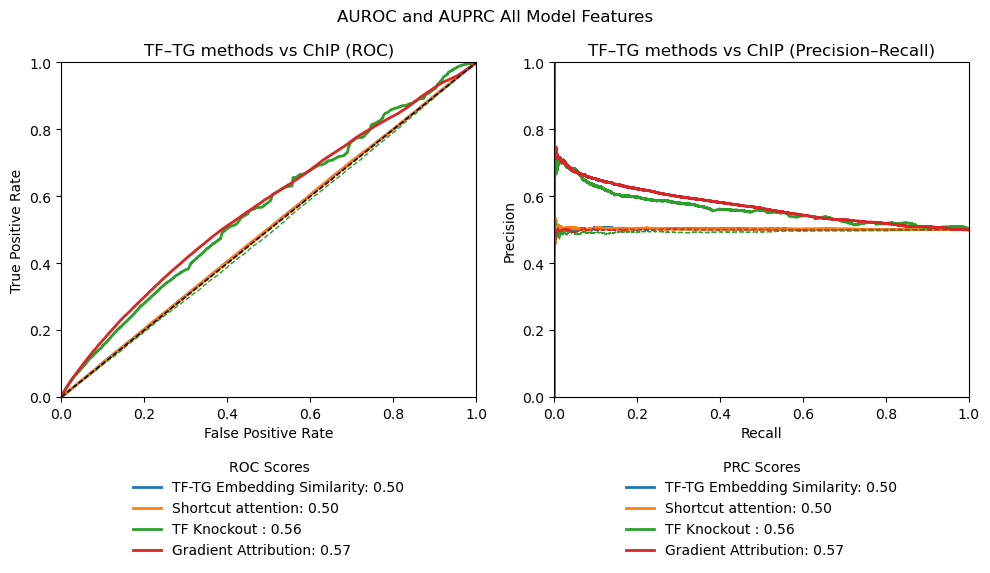

In [131]:
all_feature_fig = all_feature_auroc_auprc(feature_dict)
all_feature_fig.show()

In [129]:
print("\nFiltering inference method dataframes to ground truth and creating label column")
for name, df in method_dict.items():
    print(f"  - {name}")
    filtered_df = filter_df_to_gene_set(df, gt_tfs, gt_tgs)
    filtered_labeled_df = label_edges(filtered_df, gt_edges)
    method_dict[name] = filtered_labeled_df


Filtering inference method dataframes to ground truth and creating label column
  - MultiomicTransformer
  - Cell Oracle
  - FigR
  - Linger
  - GRaNIE
  - Pando
  - SCENIC+
  - Tripod


### Plot All Method AUROC and AUPRC

Loading MultiomicTransformer
Loading Cell Oracle
Loading FigR
Loading Linger
Loading GRaNIE
Loading Pando
Loading SCENIC+
Loading Tripod


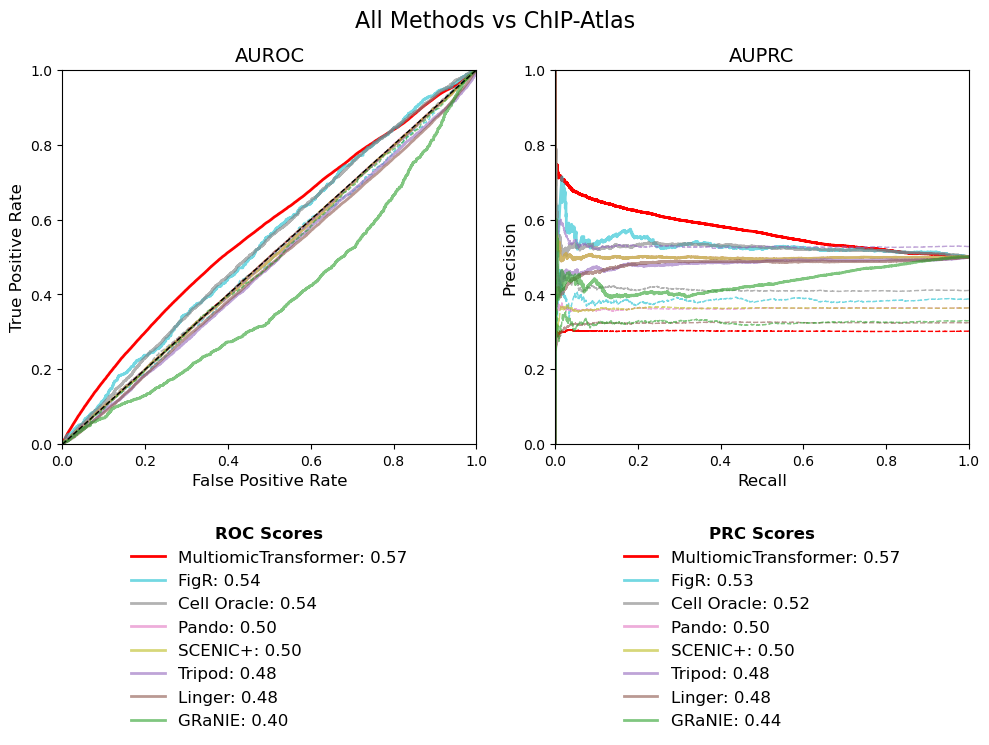

In [139]:
fig = plot_all_method_auroc_auprc(method_dict, gt_name)
fig.show()